In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

**GROUP 29**

Boscarin, Giuliano  \
Röhnelt, Charlotte \
van Engelen, Ralph 
 

![alt text](wallpaper.png)

# "Assessing the Impact of Renewable Energy Expansion on Energy Poverty amoung EU Countries"

## 1. Background and Research Questions 

The aim of this analysis is to understand how the expansion of renewable energy affects energy poverty. This analysis is closely linked to the 7th SDG "Affordable and Clean Energy" which aims to achieve access to affordable, reliable, sustainable and modern energy for all [1]. In the EU, energy poverty is still a major issue. In 2022, more than 41 million Europeans will not be able to heat their homes adequately [2]. The problem is closely linked to climate policy, energy transition and the energy crisis. With the EU Green Deal formulating targets to become climate neutral by 2050, the expansion of renewable energy is a critical component [3]. Therefore, this analysis aims to examine the impact of renewable energy expansion on energy poverty. According to the EU, the main indicators of energy poverty are arrears on utility bills, low absolute energy expenditure, high energy expenditure as a percentage of income and the inability to keep the home adequately warm [2]. By examining the relationship between renewable energy capacity, these energy poverty indicators and relevant economic factors, this analysis aims to provide insights into the social and economic impacts of the EU's renewable energy expansion. Understanding these dynamics is essential for formulating policies that balance climate goals with the socio-economic well-being of European citizens.


### Research Questions:

1. What has been the overall trend in renewable energy in the EU in recent years, and which countries have the highest shares and strongest growth?
2. To what extent has the increase in renewable energy capacity contributed to reducing energy poverty in the EU?
3. Is there a relation between GDP-pro-capite and Renewables Energy Adoption?
4. Finally, some forecastings over the next years


## 2. Data sources

To perform this analysis, the following indicators and datasets have been used:

**Renewable Energy Data:** 

- Share of renewables in total energy consumption by country (e.g., solar, wind, hydro, biomass). <span style="color:blue">**sdg_07_40    [4]**</span>. 

**Energy Poverty Indicators:**

- Share of population unable to keep home adequately warm by poverty status <span style="color:blue">**ilc_mdes01[5]**</span>. 

- Number of people in arrears on utility bills. <span style="color:blue">**ilc_mdes07 [6]**</span>.


**Economic Indicators:**
- GDP pro capita (in current US$). <span style="color:blue">**NY.GDP.PCAP.CD [7]**</span>



## 3. Pre-processing

## 3.1 Data collection and cleaning

<span style="color:red">**Compile and Run Appendix before continuing**</span>.

### Renewable Energy Data:

- **Share of renewables in total energy consumption by country every year (e.g., solar, wind, hydro, biomass)**: The indicator measures the share of renewable energy consumption in gross final energy consumption according to the Renewable Energy Directive. The gross final energy consumption is the energy used by end-consumers (final energy consumption) plus grid losses and self-consumption of power plants <span style="color:blue">[4]</span>.

**Geo** = EU Country \
**Time Frequency** = Yearly\
**Unit** = Percentage

In [7]:
share_renewables_energy = load_and_clean_data(

    file_path="sdg_07_40.csv",
    relevant_columns=['geo', 'TIME_PERIOD', 'unit', 'OBS_VALUE'],
    change_names =['Country', 'Year', 'SRE_Unit', 'SRE_Value' ]
)

#share_renewables_energy

### Energy Poverty Indicators:

- **Share of population unable to keep home adequately warm** : The indicator measures the share of population who are unable to keep home adequately warm: The indicator measures the share of population who are unable to afford to keep home adequately warm. Data for this indicator are being collected as part of the European Union Statistics on Income and Living Conditions (EU-SILC) to monitor the development of poverty and social inclusion in the EU. The data collection is based on a survey, which means that indicator values are self-reported <span style="color:blue"> [5]</span>.

**Geo** = EU Country \
**Time Frequency** = Yearly\
**Unit** = Percentage

In [8]:
unable_heating_home = load_and_clean_data(
    
    file_path= "ilc_mdes01.csv",
    relevant_columns=['geo', 'TIME_PERIOD', 'unit', 'OBS_VALUE'],
    change_names =['Country', 'Year', 'UHH_Unit', 'UHH_Value' ],
)

#unable_heating_home

- **Number of people in arrears on utility bills**: The indicator
represents the share of (sub-) population with
arrears on utility bills, based on the question
"In the last twelve months, has the household been in arrears, i.e., has
been unable to pay on time due to financial difficulties for utility bills
(heating, electricity, gas, water, etc.) for the main dwelling?" <span style="color:blue"> [6]</span>.

**Geo** = EU Country \
**Time Frequency** = Yearly\
**Unit** = Percentage

In [14]:
utility_bills_difficulty = load_and_clean_data(
    
    file_path="ilc_mdes07.csv",
    relevant_columns=['geo', 'TIME_PERIOD', 'unit', 'OBS_VALUE'],
    change_names =['Country', 'Year', 'UBD_Unit', 'UBD_Value' ]
)

#utility_bills_difficulty

### Economic indicators:

- **GDP pro capita (in current US$)**: GDP per capita is gross domestic product divided by midyear population. <span style="color:blue"> [7]</span>

In [10]:
df_GDP_per_capita = pd.read_csv("GDP_per_capita_world_bank.csv")


# Map the World Bank country codes to Eurostat codes
wb_to_eurostat_map = {
    'AUT': 'AT', 'BEL': 'BE', 'BGR': 'BG', 'HRV': 'HR', 'CYP': 'CY', 'CZE': 'CZ', 'DNK': 'DK',
    'EST': 'EE', 'FIN': 'FI', 'FRA': 'FR', 'DEU': 'DE', 'GRC': 'EL', 'HUN': 'HU', 'IRL': 'IE',
    'ITA': 'IT', 'LVA': 'LV', 'LTU': 'LT', 'LUX': 'LU', 'MLT': 'MT', 'NLD': 'NL', 'POL': 'PL',
    'PRT': 'PT', 'ROU': 'RO', 'SVK': 'SK', 'SVN': 'SI', 'ESP': 'ES', 'SWE': 'SE', 'ISL': 'IS',
    'LIE': 'LI', 'NOR': 'NO', 'CHE': 'CH', 'ALB': 'AL', 'BIH': 'BA', 'MNE': 'ME', 'MKD': 'MK',
    'SRB': 'RS', 'TUR': 'TR', 'XKX': 'XK', 'GBR': 'UK'
}

# Add Eurostat codes to the World Bank data
df_GDP_per_capita['Eurostat Code'] = df_GDP_per_capita['Country Code'].map(wb_to_eurostat_map)

# Filter for relevant countries only
eurostat_countries = ['AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'EL', 'HU', 'IE', 'IT',
                      'LV', 'LT', 'LU', 'MT', 'NL', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE', 'IS', 'LI', 'NO',
                      'CH', 'AL', 'BA', 'ME', 'MK', 'RS', 'TR', 'XK', 'UK']

filtered_df_GDP_per_capita = df_GDP_per_capita[df_GDP_per_capita['Eurostat Code'].isin(eurostat_countries)].copy()

# Convert year columns to numeric in both datasets and clean income share data
for col in filtered_df_GDP_per_capita.columns:
    if 'YR' in col:
        filtered_df_GDP_per_capita[col] = pd.to_numeric(filtered_df_GDP_per_capita[col], errors='coerce')

# Reshape (melt) the filtered World Bank data to align with time period format
filtered_df_GDP_per_capita = filtered_df_GDP_per_capita.melt(id_vars=['Country Code', 'Eurostat Code'], var_name='time_period', value_name='GDP_per_capita')

# Extract the year from 'time_period' and handle NaNs before conversion
filtered_df_GDP_per_capita['time_period'] = filtered_df_GDP_per_capita['time_period'].str.extract('(\d+)', expand=False)
filtered_df_GDP_per_capita.dropna(subset=['time_period'], inplace=True)  # Drop rows where 'time_period' is NaN
filtered_df_GDP_per_capita['time_period'] = filtered_df_GDP_per_capita['time_period'].astype(int)
filtered_df_GDP_per_capita = filtered_df_GDP_per_capita.sort_values(by='Eurostat Code').reset_index(drop=True)
filtered_df_GDP_per_capita.dropna(subset=['GDP_per_capita'], inplace=True)
filtered_df_GDP_per_capita.drop(columns=['Country Code'], inplace=True)
filtered_df_GDP_per_capita.rename(columns={'Eurostat Code': 'Country', "time_period": "Year"}, inplace=True)
#filtered_df_GDP_per_capita

## 3.2 Elaboration

- Calculate the YoY Growth and Absolute Change and add a country named 'AVERAGE' that contains all the means value of all the countries per year

In [11]:
def process_dataset_with_rates_and_average(data, value_column, unit_column):
    """
    Processes a dataset in place to compute Year-over-Year Growth (%),
    Absolute Year-over-Year Change, and adds an 'AVERAGE' country row
    that represents the mean values for all other columns for each year.

    Parameters:
    - data (pd.DataFrame): The dataset to process, which will be modified in place.
    - value_column (str): The column name containing the values to calculate YoY changes.

    Returns:
    - the new DataFrame: the DataFrame updated.
    """
    # Calculate YoY Growth (%) by country in place
    data['YoY Growth (%)'] = data.groupby('Country')[value_column].pct_change() * 100
    
    # Calculate absolute YoY Change by country in place
    data['YoY Absolute Change'] = data.groupby('Country')[value_column].diff()

    # Calculate the yearly averages across all columns except 'Country'
    yearly_avg = data.groupby('Year')[[value_column, 'YoY Growth (%)', 'YoY Absolute Change']].mean().reset_index()
    
    # Add a 'Country' column and set it to 'AVERAGE'
    yearly_avg['Country'] = 'AVERAGE'
    yearly_avg[unit_column] = 'PC'
    
    # Concatenate the average data to the original DataFrame in place
    data = pd.concat([data, yearly_avg],ignore_index=True)
    
    data.reset_index(drop=True, inplace=True)
    
    return data

    

# Processing all the dataframes:

share_renewables_energy = process_dataset_with_rates_and_average(share_renewables_energy, value_column = 'SRE_Value', unit_column = 'SRE_Unit')

unable_heating_home = process_dataset_with_rates_and_average(unable_heating_home, value_column =  'UHH_Value', unit_column = 'UHH_Unit')

utility_bills_difficulty = process_dataset_with_rates_and_average(utility_bills_difficulty, value_column =  'UBD_Value', unit_column = 'UBD_Unit')

## 4. Analysis

### 4.1 Trend Analysis of Renewable Energy Expansion

**In 2020 the average share of renewables energy in the European Union has reached 22%** 

Over the past 20 years, European countries have significantly increased their share of renewable energy due to strong policy frameworks, technological advancements, and rising public awareness of climate change. Investments in solar, wind, and biomass have surged. On average, in 2020, the 22% of the gross final energy consumption in the European Union comes from renewable sources, leading to an increase of 120% from the 10% share in 2005. To showcase this trend, running the function below will show the share of renewable energy over an adjustable time period. In the box countries, the country or countries of interest can be specified. One can also inspect the average. 

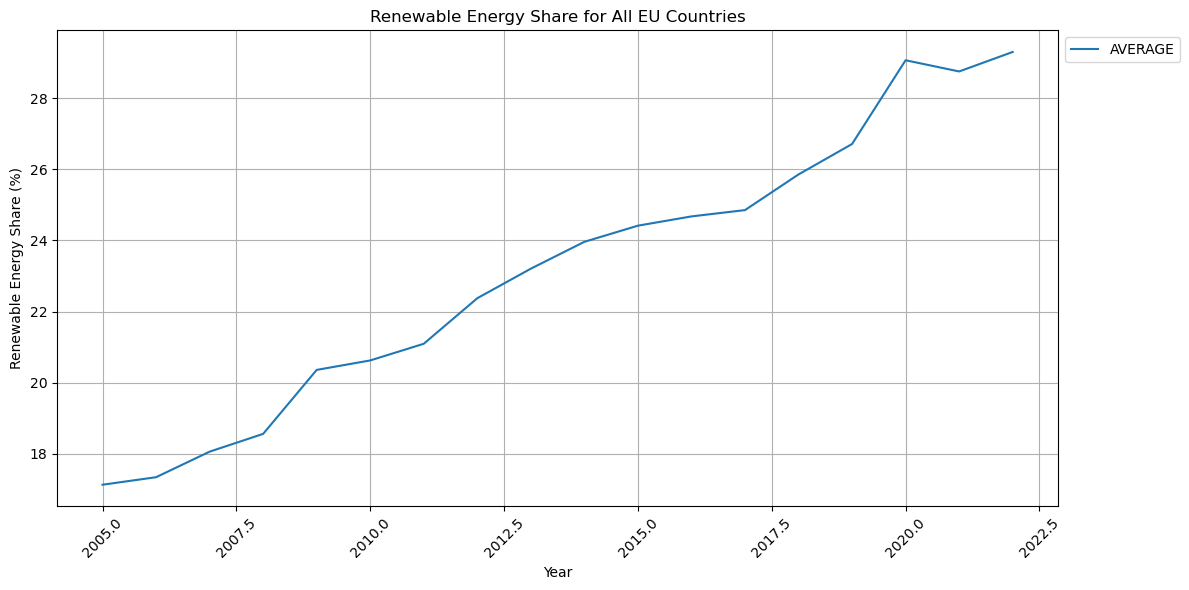

In [12]:
plot_share_renewables_energy(
    share_renewables_energy,
    countries= ['AVERAGE'],    #put None for all the countries, or the list of selected countries 
    start_year = 2005,
    end_year = 2022,
    title="Renewable Energy Share for All EU Countries"
)

**But what are the trends of the individual countries?**

**Share of renewable energy per country (%) compared between 2005 and 2020**

The graph below showcases the share of renewables of countries of the year 2005 and 2020, highlighting the relative change of each country.

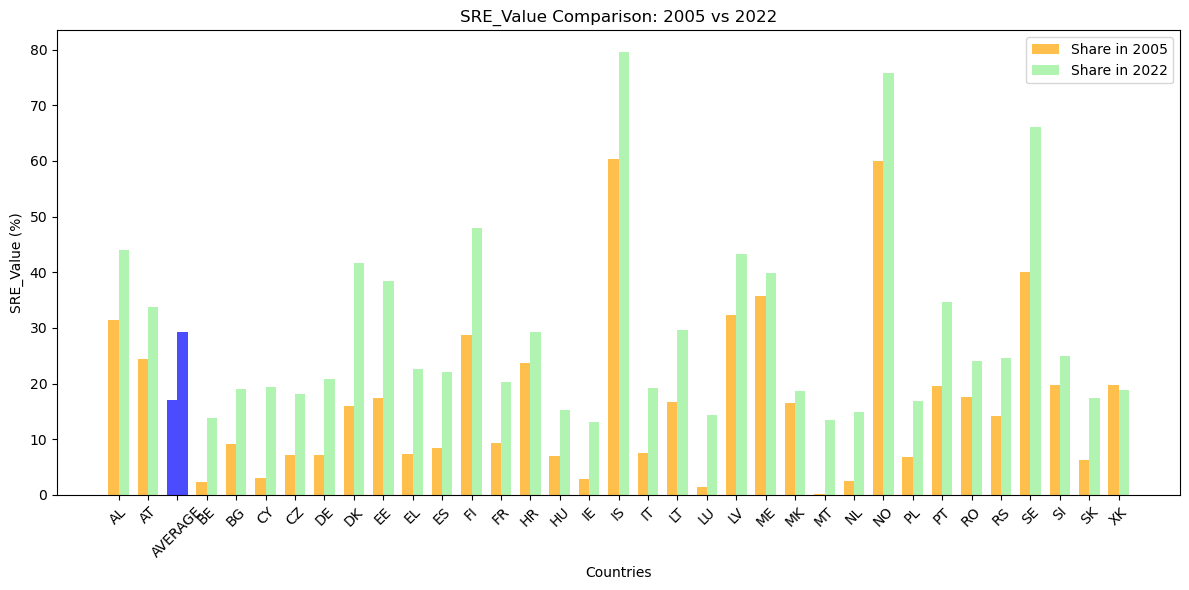

In [13]:
plot_share_different_years(share_renewables_energy, 'SRE_Value', 2005, 2022)

Noticable is that a low share of renewable energy does not necessarily mean a low increase in renewables as is seen with countries such as Belgium, Croatia or lithuania. Additonally, a high share of renewables does not ensure a high change in renewables as is seen with the countries Siberia, Albania, Latvia or Norway. This is crucial for providing context when later comparing it to energy poverty indicators. Using absolute values for the share of renewable energy alone wouldn't reveal how transitioning to renewable energy impacts poverty.

- **Compound Annual Growth Rate (%):**

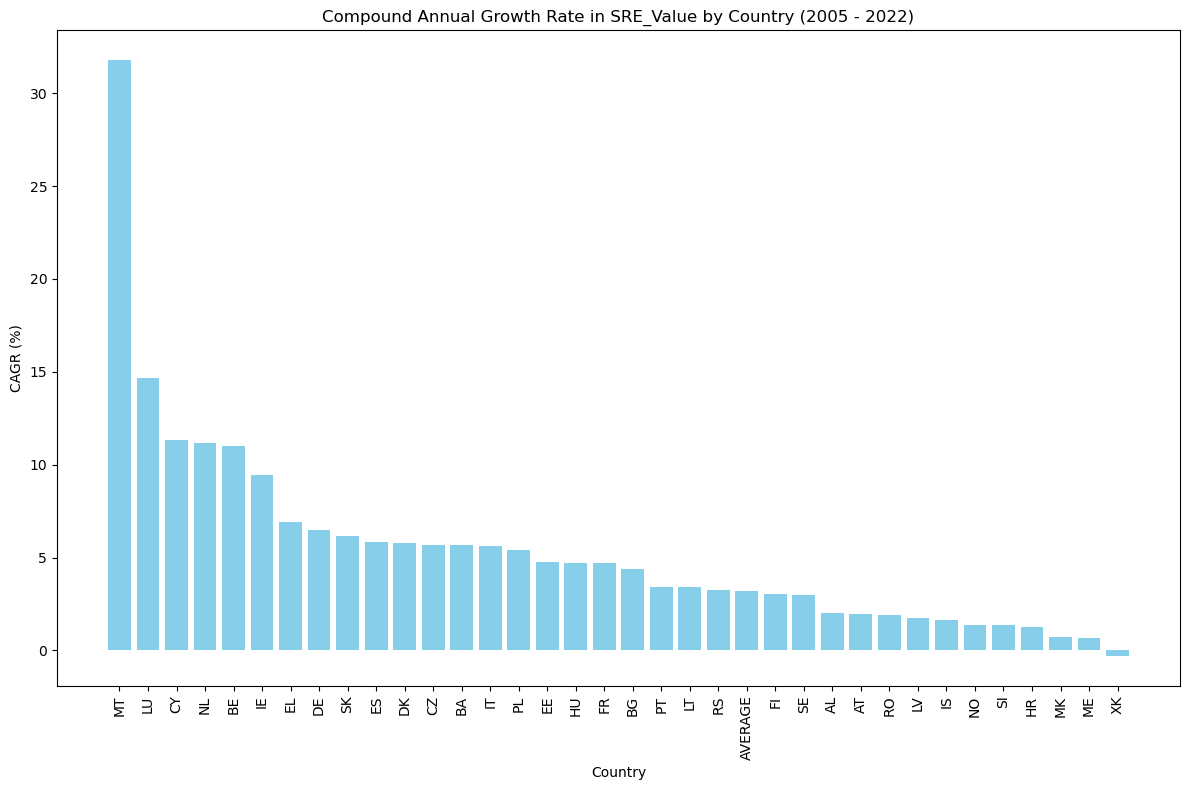

In [12]:
# plot_CAGR(your_dataframe, 2010, 2020)

plot_CAGR(share_renewables_energy, 'SRE_Value', 2005, 2022)    

This graphs shows that more countries are above the average compound trend (21) then below it (14). Noticably, Montenegro has the highest compound growth of almost 35%. These results should be compared to the graph below of absolute values to analyse the differences in countries with a high/low absolute growth of share of renewables and countries with a high/low relative growth.

**Growth in Absolute Values**

The boxplot below shows the absolute growth in % of each country.


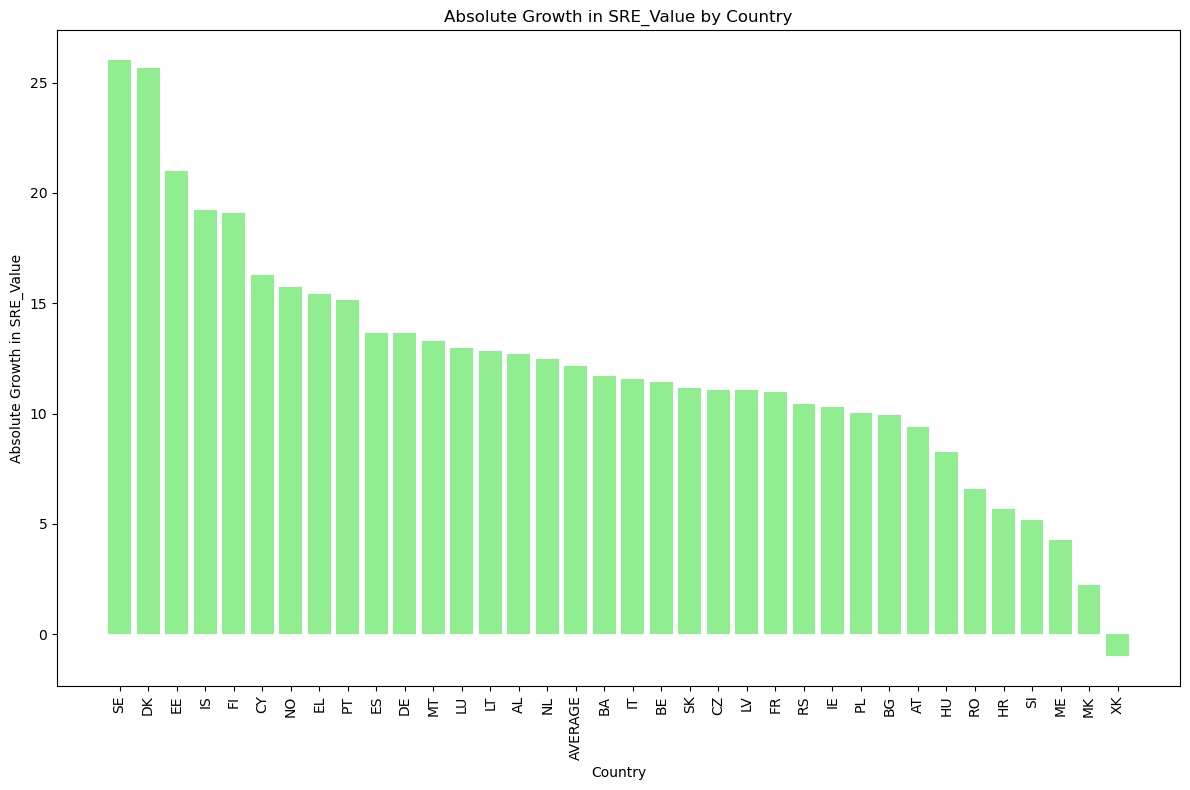

In [15]:
plot_absolute_growth(share_renewables_energy, value_col='SRE_Value', start_year=2005, end_year=2022)

When comparing this plot of absolute growth with the plot of compound growth what stands out is that a lot of countries that are in the compound growth plot left of the average are on this absolute growth plot on the right of the average, showing that a lot of countries with a low absolute growth did grow a lot relatively and visa versa. Examples of this are, Montenegro, Lithuania, the Netherlands and Belgium.
Examples of countries with high absolute growth but low relative growth are: Iceland, Sweden, Norway and Finland.

### 4.2 Correlation Analysis Between Renewable Energy and Energy Poverty

### 4.2.1 Correlation Analysis Between Renewable Energy and Share of Population unable to keep their house warm enough

**Trend in Home Heating Adequacy Among EU Countries (2005-2022):**

The percentage of the population in EU countries unable to keep their homes adequately warm shows a gradual decline over the years, with some ups and downs. Starting around 14% in 2005, by 2022, this percentage drops to around 9%, reflecting a noticeable improvement in energy poverty reduction across the EU. 

The fluctuations may indicate periods of economic strain or energy price increases. Possible events might be the 2008 crisis or the European Debt crisis from 2009 until the mid to late 2010s.

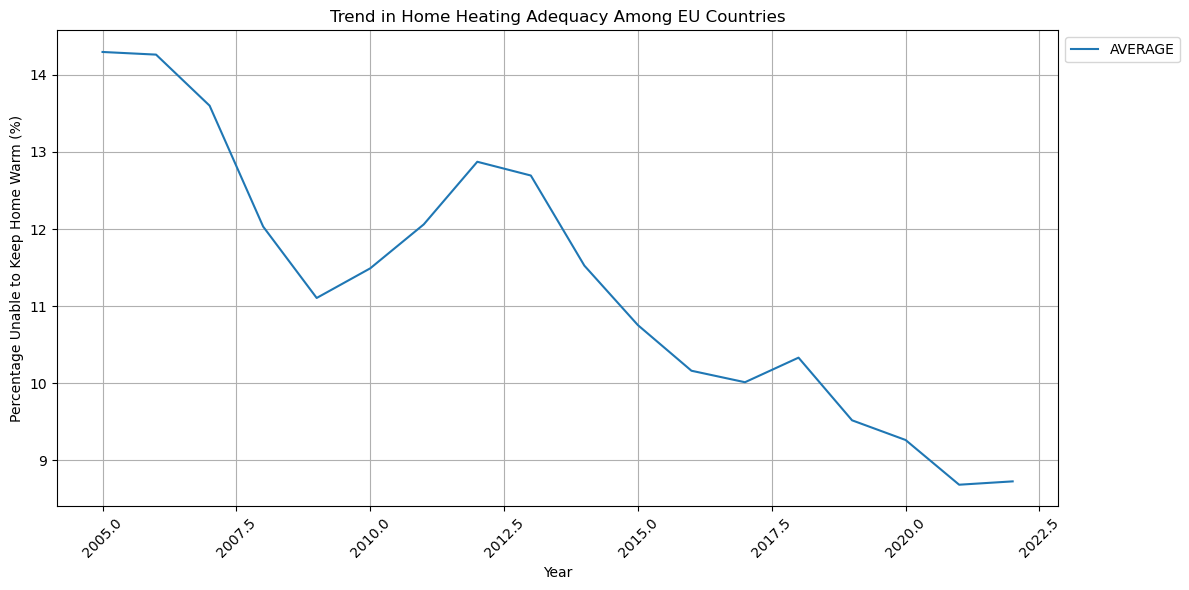

In [67]:
plot_unable_heating_home(
    unable_heating_home, 
    countries=['AVERAGE'], 
    start_year=2005, 
    end_year=2022,
    title="Trend in Home Heating Adequacy Among EU Countries"
)

**Home Heating Inadequacy Comparison: 2005 vs 2022:**

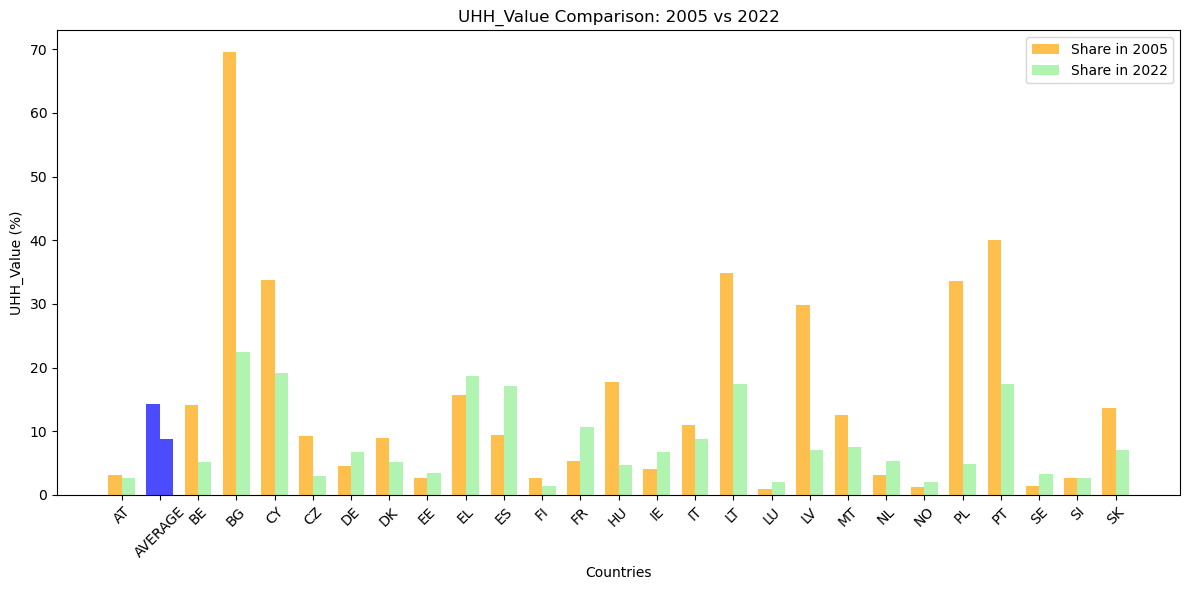

In [70]:
plot_share_different_years(unable_heating_home, 'UHH_Value', 2005, 2022)

In detail the above bar chart help us to understand how the levels of the singular countries developed beetwen 2005 and 2020.

Many countries, as **Bulgaria (BG) and Poland (PL) and Latvia (LV)**, show substantial reductions, moving from high rates of heating inadequacy in 2005 to significantly lower levels in 2022. **Lituania (LT), Portugal (PT) and Cyprus (CY)** also reflect notable improvements, though they remain above the EU average, indicating persistent challenges. 
 
In contrast, **Sweden (SE), Norway (NO) and Finland (FI)** maintain consistently low rates across both years, highlighting their strong performance in ensuring adequate home heating. 

Notably, **Spain (ES)** is one of the few countries showing an increase over this period, pointing to emerging issues in this area. Overall, this comparison underscores both the progress made in some regions and the remaining disparities within the EU.

**Cross-Correlation Between Renewable Energy Share and Home Heating Inadequacy**

Having analyzed trends in home heating inadequacy over the past few years, we now aim to investigate whether there is a strong correlation between the increase of renewable energy sources and decreasing rates of energy poverty. To do so we'll analyze the cross-correlation factors between the two indicators by each country

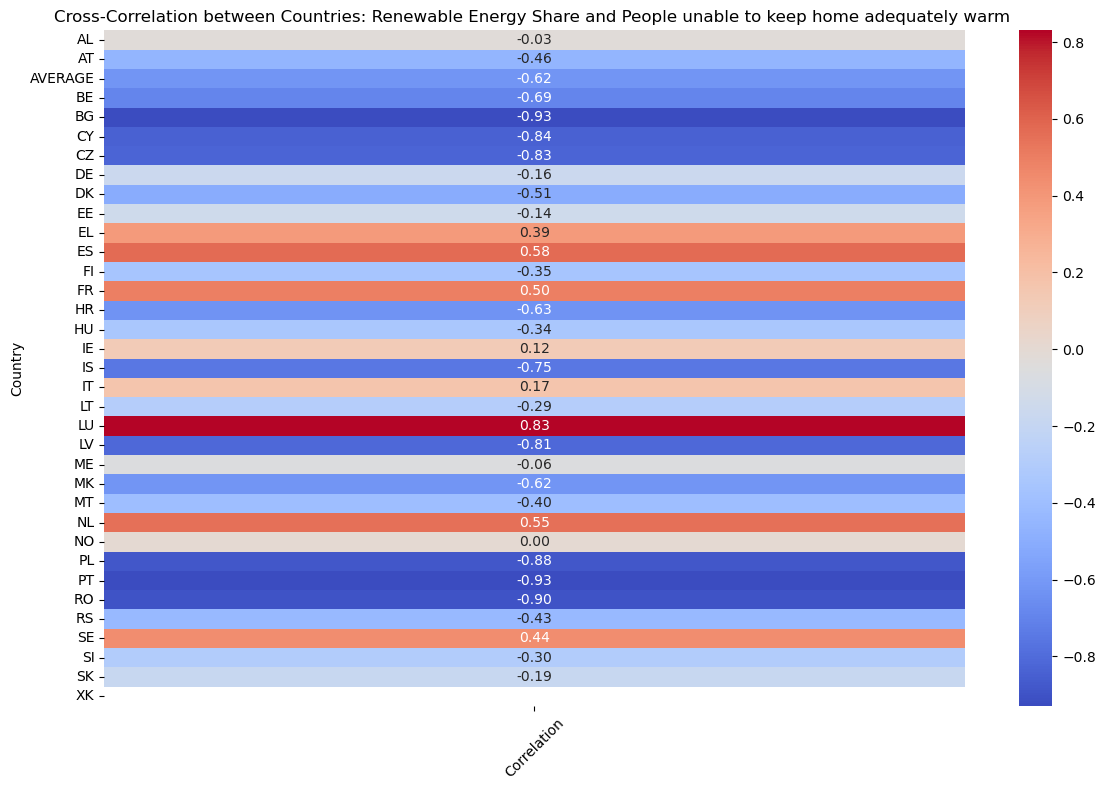

In [14]:
"""
Calculating the cross-correlation by each country between the following time-series: share of renewables energy 
and share of population unable to keep home adequately warm.

"""


# Merge the DataFrames based on common columns (like 'Country' and 'Year')
merged_data = pd.merge(share_renewables_energy, unable_heating_home, on=['Country', 'Year'])

# Pivot the DataFrame to get countries as columns
renewable_pivot = merged_data.pivot(index='Year', columns='Country', values='SRE_Value')
unable_pivot = merged_data.pivot(index='Year', columns='Country', values='UHH_Value')

# Calculate the cross-correlation for each pair of countries
cross_correlation = renewable_pivot.corrwith(unable_pivot)

# Convert the Series to a DataFrame for better visualization
cross_correlation_df = pd.DataFrame(cross_correlation, columns=['Correlation'])

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cross_correlation_df, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Cross-Correlation between Countries: Renewable Energy Share and People unable to keep home adequately warm ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Generally, a pattern of negative correlations is observed, suggesting that in many EU countries, increasing shares of renewable energy are associated with a proportional decrease in the percentage of households experiencing heating inadequacy. This implies that an increase in renewable energy may contribute to more affordable or reliable heating options, thus reducing energy poverty.

Among the countries with the strongest negative correlations, **Bulgaria (BG)**, **Portugal (PT)**, and **Romania (RO)** stand out. For these nations, the correlation values approach -0.9, indicating a very strong relationship where increased renewable energy share is linked with significant reductions in the number of people struggling to heat their homes.

Several other countries, such as **Hungary (HU)**, **Cyprus (CY)**, and **Poland (PL)**, also show negative correlations, though to a slightly lesser extent. These results still imply that renewable energy has a role in improving heating adequacy, but other factors may also be influencing the outcomes in these countries, perhaps economic factors, differences in energy infrastructure, or the presence of subsidies for fossil fuels.

On the opposite end, **Luxembourg (LU)** and **Spain (ES)** exhibit positive correlations, meaning that as renewable energy shares have increased, there hasn’t been a corresponding reduction in energy poverty related to heating; in fact, it may have even worsened. This suggests that, in these countries, renewable energy adoption has not yet translated effectively into improved heating conditions for lower-income or energy-vulnerable households. The reasons for these positive correlations could include high costs associated with renewable infrastructure, insufficient policies to ensure affordable energy distribution, or reliance on other non-renewable energy sources that still dominate the heating market.

Additionally, countries like **Norway (NO)** and **Albania (AL)** show near-zero correlations, indicating a weak or negligible relationship between renewable energy share and heating adequacy. For Norway, this could be due to its already high levels of renewable energy and stable heating infrastructure, while in Albania, other external factors might be more influential in determining energy poverty levels.

**But, is there a general reason why some countries have better results?**

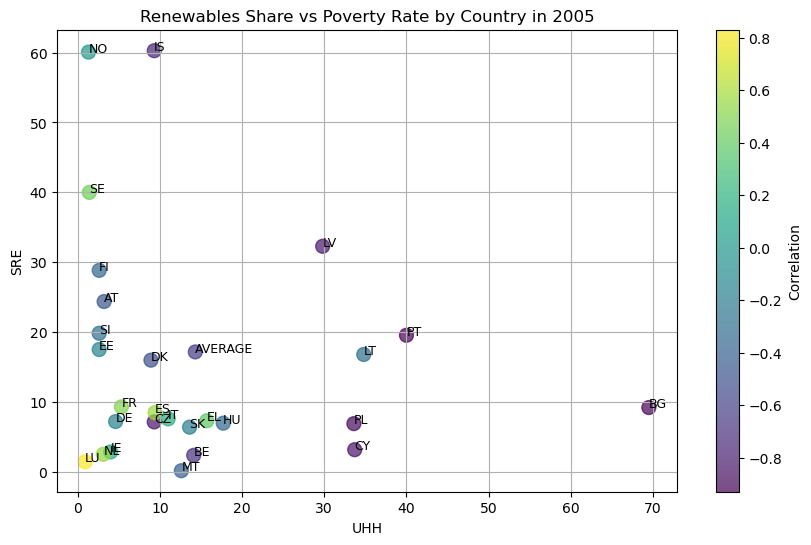

In [15]:

# Filter relevant columns 
merged_data = merged_data[['Country', 'Year', 'SRE_Value', 'UHH_Value']]

# Filter DataFrame for the specific year
year = 2005
df_filtered = merged_data[merged_data['Year'] == year]

final_df = pd.merge(df_filtered,cross_correlation_df , on=['Country'])

# Plot with color and size based on 'Correlation'
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    final_df['UHH_Value'], 
    final_df['SRE_Value'], 
    c=final_df['Correlation'],  # Color by 'Correlation'
    s=100,  # Increase point size
    cmap='viridis',  # Use a color map
    alpha=0.7  # Transparency for better readability
)

# Add a color bar to show the scale of 'Correlation'
plt.colorbar(sc, label='Correlation')

# Add labels for each country
for i, row in df_filtered.iterrows():
    plt.text(row['UHH_Value'], row['SRE_Value'], row['Country'], fontsize=9)

# Set plot labels and title
plt.xlabel('UHH')
plt.ylabel('SRE')
plt.title(f'Renewables Share vs Poverty Rate by Country in {year}')
plt.grid(True)
plt.show()


In the plot above, we illustrate the positioning of countries based on their share of renewable energy and the percentage of the population unable to adequately heat their homes at the start of our analysis- 2005. Additionally, the previously identified cross-correlation for each country is incorporated into the plot. It reveals that countries with a strong negative correlation — those that stand to gain the most by increasing their renewable energy share over the next 15 years — tend to **have higher initial rates of inadequate home heating (UHH) and a moderate to low share of renewables**. Conversely, countries exhibiting low or positive correlations are those with already low UHH rates. The plot also indicates that nations with a **high share of renewable energy have correspondingly low rates of energy poverty**

This means that countries with higher initial rates of inadequate home heating have significant potential to improve their energy conditions by increasing their reliance on renewable energy. The analysis suggests that by transitioning to renewable sources, these countries could not only reduce heating inadequacy but also alleviate energy poverty over time. On the other hand, countries that already have low rates of inadequate heating may not experience the same benefits from increasing their renewable energy share, as their current energy conditions are already favorable. 

### 4.2.2 Correlation Analysis Between Renewable Energy and Share of Population in arreas on utility bills

**Trend in Utility Bills Difficulty Among EU Countries (2005-2022)**


The percentage of EU residents reporting difficulty paying utility bills initially increased, peaking around 2015, before experiencing a significant decrease in recent years. This suggests an overall improvement in utility affordability for EU households over the last decade, potentially due to various economic or policy-driven factors.

The fluctuations indicate moments of economic strain or price hikes, likely impacted by the 2008 financial crisis and the European Debt Crisis in the early 2010s. However, since 2015, the trend has generally been downward, reflecting reduced energy cost burdens for many EU residents.

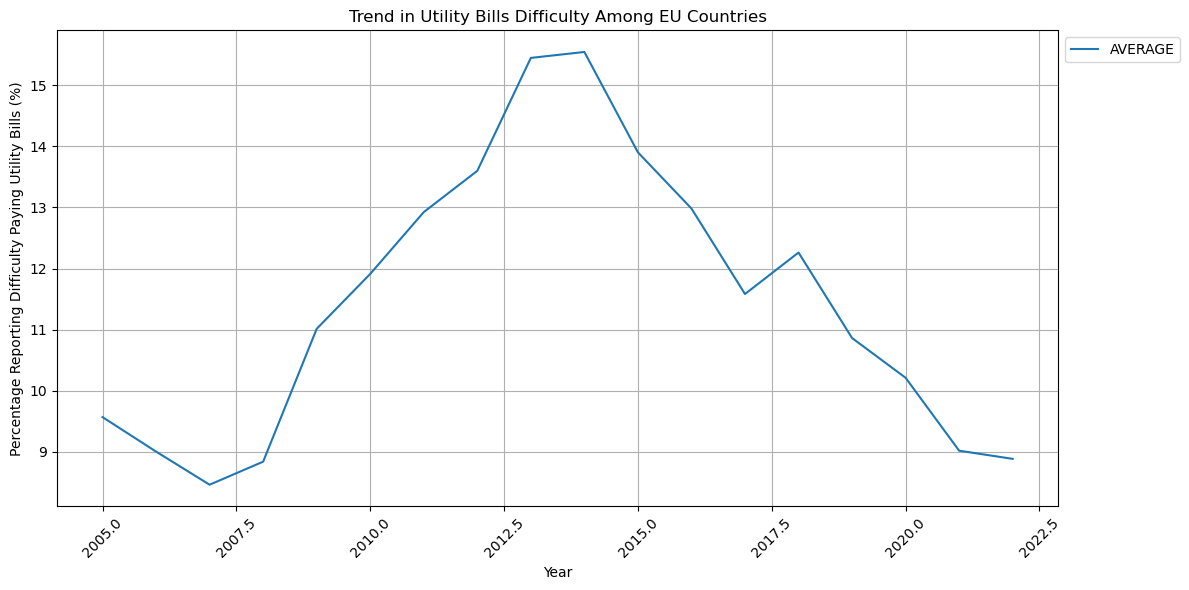

In [65]:
plot_utility_bills_difficulty(
    utility_bills_difficulty, 
    countries=['AVERAGE'], 
    start_year=2005, 
    end_year=2022,
    title="Trend in Utility Bills Difficulty Among EU Countries"
)

- <span style="color:blue">**Discussion**</span>.

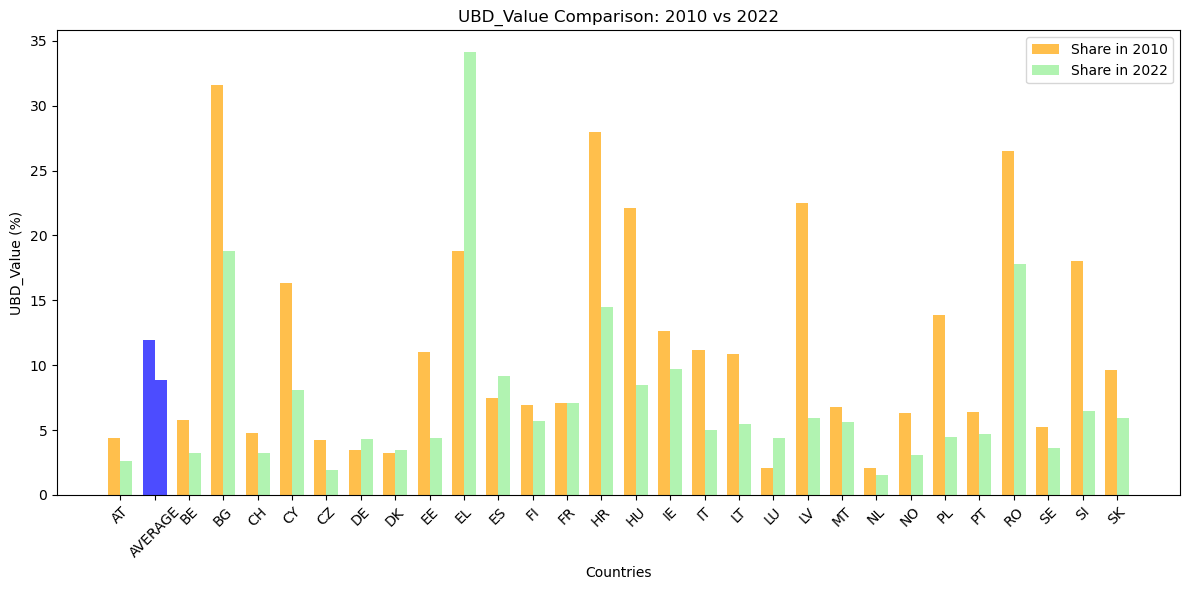

In [66]:
plot_share_different_years(utility_bills_difficulty, 'UBD_Value', 2010, 2022)

In the bar chart comparing individual countries, significant variations can be observed:

**Countries with High Initial Rates and Improvement:** Several countries, like Bulgaria (BG) and Lativa (LV), saw substantial declines from 2005 to 2022, suggesting successful interventions or economic improvements that reduced household struggles with utility bills.

**Countries with Consistently Low Rates:** Sweden (SE), Nederlands (NO), and Austria (AU) maintained consistently low difficulty levels across both years, likely due to stronger economic resilience and efficient energy policies.

**Countries with Rising Difficulty:** Interestingly, Greece (EL) shows an increase from 2005 to 2022, indicating emerging affordability issues in this area, potentially due the Sovereign Debt Crisis.

This chart highlights the variation in energy cost burdens across Europe, with countries making notable progress, others with sustained stability, and some facing new challenges.

**Cross-Correlation Between Renewable Energy Share and Utility Bills Difficulty**

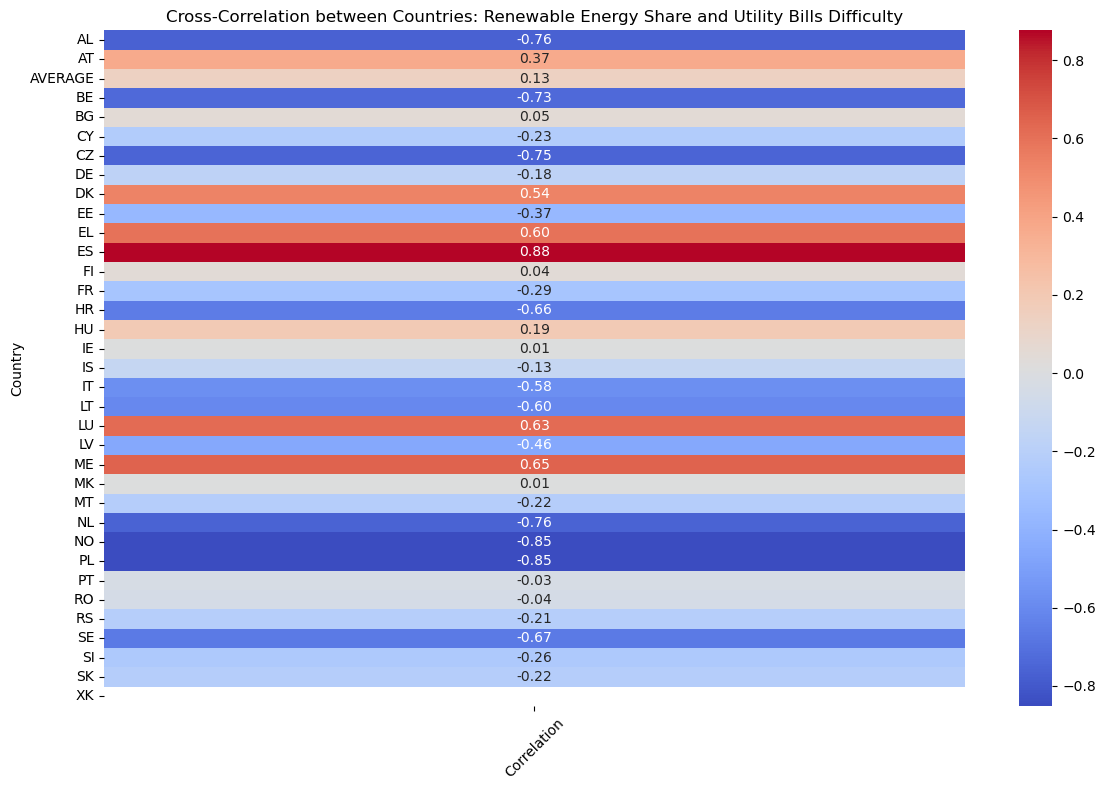

In [61]:
"""
Calculating the cross-correlation by each country between the following time-series: share of renewables energy 
and share of population in arrears on utility bills.

"""


# Merge the DataFrames based on common columns (like 'Country' and 'Year')
merged_data = pd.merge(share_renewables_energy, utility_bills_difficulty, on=['Country', 'Year'])

# Pivot the DataFrame to get countries as columns
renewable_pivot = merged_data.pivot(index='Year', columns='Country', values='SRE_Value')
utility_pivot = merged_data.pivot(index='Year', columns='Country', values='UBD_Value')

# Calculate the cross-correlation for each pair of countries
cross_correlation = renewable_pivot.corrwith(utility_pivot)

# Convert the Series to a DataFrame for better visualization
cross_correlation_df = pd.DataFrame(cross_correlation, columns=['Correlation'])

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cross_correlation_df, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Cross-Correlation between Countries: Renewable Energy Share and Utility Bills Difficulty')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In this case, in the heatmap of cross-correlation values between renewable energy share and utility bill difficulty, we observe less marked general trend of negative correlations, with a few countries with high negative values, and the majority of countries with very low correlation.

**Strong Negative Correlations:** Countries like Poland (PL), Beliuma (BG), and Romania (RO) exhibit highly negative correlations, close to -0.9. This suggests that increasing renewable energy adoption is linked with significantly reduced utility cost burdens for households.

**Strong Positive Correlations:** Spain (ES) shows a strong positive correlation, where increased renewable energy share has not corresponded to reduced energy poverty, and in some cases, affordability challenges have grown. This may imply that renewable energy benefits are not effectively reaching vulnerable households, possibly due to high transition costs or other economic factors.

**Minimal Correlations:** For countries like Finland (FI) and Bulgaria (BG), there is little to no correlation, likely due to existing energy stability or factors outside renewable energy impacting utility bill difficulty.


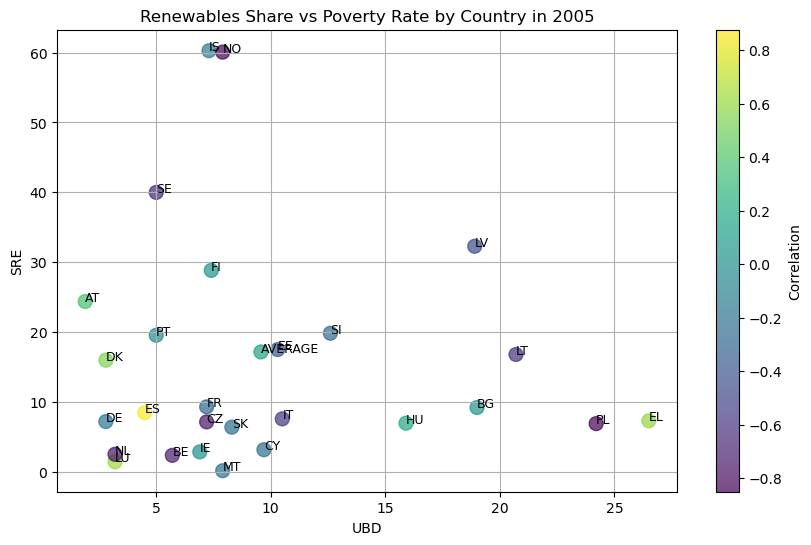

In [62]:
# Filter relevant columns 
merged_data = merged_data[['Country', 'Year', 'SRE_Value', 'UBD_Value']]

# Filter DataFrame for the specific year
year = 2005
df_filtered = merged_data[merged_data['Year'] == year]

final_df = pd.merge(df_filtered,cross_correlation_df , on=['Country'])

# Plot with color and size based on 'Correlation'
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    final_df['UBD_Value'], 
    final_df['SRE_Value'], 
    c=final_df['Correlation'],  # Color by 'Correlation'
    s=100,  # Increase point size
    cmap='viridis',  # Use a color map
    alpha=0.7  # Transparency for better readability
)

# Add a color bar to show the scale of 'Correlation'
plt.colorbar(sc, label='Correlation')

# Add labels for each country
for i, row in df_filtered.iterrows():
    plt.text(row['UBD_Value'], row['SRE_Value'], row['Country'], fontsize=9)

# Set plot labels and titl
plt.xlabel('UBD')
plt.ylabel('SRE')
plt.title(f'Renewables Share vs Poverty Rate by Country in {year}')
plt.grid(True)
plt.show()

The plot depicts the relationship between each country's share of renewable energy (SRE) and its poverty rate, measured by the percentage of the population in arrears on utility bills in 2005. 

Even in this case:

**High Renewable Energy Share and Low Poverty Rate:** Countries with a high share of renewables (like Norway and Iceland, in the upper-left region) generally have lower poverty rates, as indicated by their positions along the SRE axis.

Even if less evident, the countries that in future years will benefit the most in the expansion of renewables energy are the ones with mid-to-low share of renewables energy and mid-to-high poverty rate.



**Discussion on results of the correlation analysis and limitations**

Besides having found an overall negative correlation between renewable energy share and energy poverty rates, especially for some subsets of countries, our analysis has several limitations that should be considered.

First, correlation does not imply always causation; while higher renewable shares coincide with lower poverty rates, other socio-economic factors may drive this relationship. 

Second, external variables like economic stability, government subsidies, and energy pricing policies play a significant role in poverty levels, potentially confounding the impact of renewable energy alone. 

Third, geographic and climatic differences impact a country's ability to expand renewables, limiting the generalizability of these findings. 

Future research should consider a more comprehensive model that includes these factors.

### 4.3 Analysis Between Renewable Energy and GDP-pro-capita

- <span style="color:blue">**Discussion**</span>.

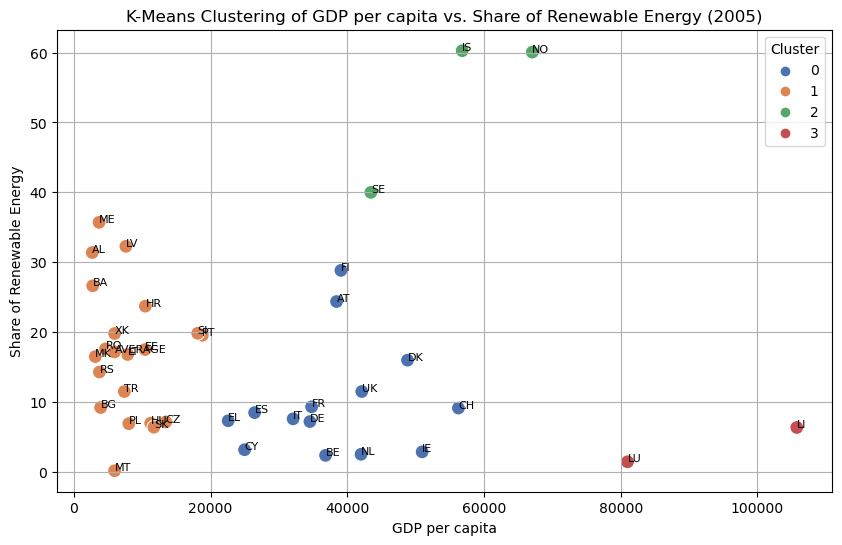

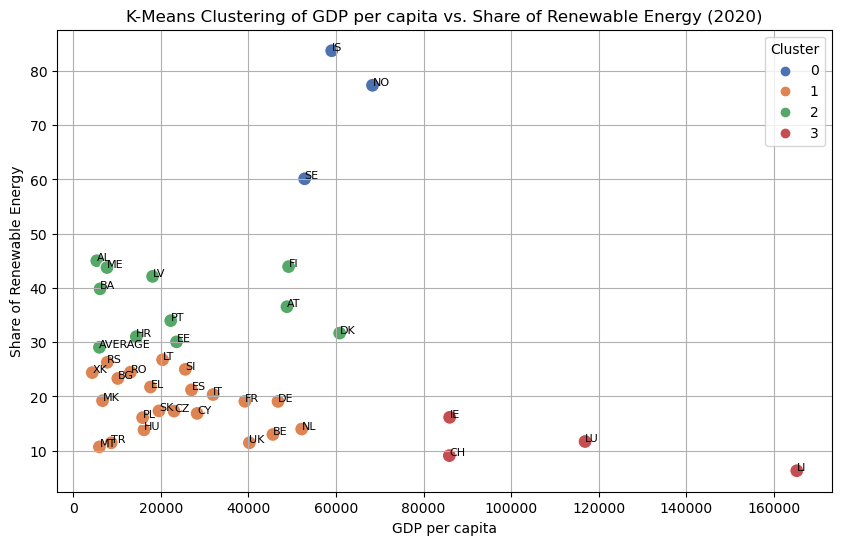

In [63]:
Renewable_and_gdp = filtered_df_GDP_per_capita.merge(share_renewables_energy, on=["Country", "Year"], how="outer")
Renewable_and_gdp.fillna(method='ffill', inplace=True)



# Define a function for clustering and plotting
def plot_clustering_for_year(year):
    # Filter data for the specified year
    data_year = Renewable_and_gdp[Renewable_and_gdp['Year'] == year].copy()
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data_year[["GDP_per_capita", "SRE_Value"]])

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
    data_year.loc[:, 'cluster'] = kmeans.fit_predict(scaled_features)  # Use .loc to avoid SettingWithCopyWarning


    # # Define cluster names
    # cluster_names = {
    #     0: 'High GDP & Low Renewable Share',
    #     1: 'Low GDP & Medium Renewable Share',
    #     2: 'Medium GDP & High Renewable Share'
    # }

    # Map cluster names to the cluster numbers
    # data_year['cluster_name'] = data_year['cluster'].map(cluster_names)

    # Plot with country names
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data_year, 
                    x='GDP_per_capita', 
                    y='SRE_Value', 
                    hue='cluster', 
                    palette='deep', 
                    s=100)

    # Annotate each point with the country name
    for i in range(data_year.shape[0]):
        plt.text(x=data_year['GDP_per_capita'].iloc[i], 
                 y=data_year['SRE_Value'].iloc[i], 
                 s=data_year['Country'].iloc[i], 
                 fontdict=dict(color='black', size=8))

    # Customize plot labels
    plt.title(f'K-Means Clustering of GDP per capita vs. Share of Renewable Energy ({year})')
    plt.xlabel('GDP per capita')
    plt.ylabel('Share of Renewable Energy')
    plt.legend(title='Cluster')
    plt.grid()
    plt.show()

# Plot for 2005
plot_clustering_for_year(2005)

# Plot for 2020
plot_clustering_for_year(2020)


**Discussion:**
The K-Means clustering analysis illustrates distinct patterns in renewable energy adoption relative to GDP per capita, highlighting economic and renewable profiles among countries in 2005 and 2020. By grouping countries with similar economic and renewable characteristics, the clusters reveal how wealthier nations might still lag in renewable adoption, while some lower-GDP countries achieve higher renewable shares. Comparing the clusters over time indicates shifts in renewable adoption, showcasing progress. What is noticeable about these graphs is that there does not appear to be a correlation between the GDP per capita of a country and the amount invested in renewable energy for the highest GDPs. Some middle-income countries in cluster 0 seem to have a higher share of renewables in 2020. However, most countries fall into cluster 1, which includes a range from low to high incomes with shares of renewables ranging from 10 to 30 percent. Also noticeable is the number of low-GDP per capita countries that still have a relatively high share of renewables in cluster 3, such as Albania, Montenegro, Bosnia, and Latvia. There is not much difference between the two years, with the spread of the clusters remaining almost the same.

## 5. Future Predictions

17:32:10 - cmdstanpy - INFO - Chain [1] start processing
17:32:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 9.196401375978873
Mean Squared Error: 84.79113565817762
Root Mean Squared Error: 9.208210230993732


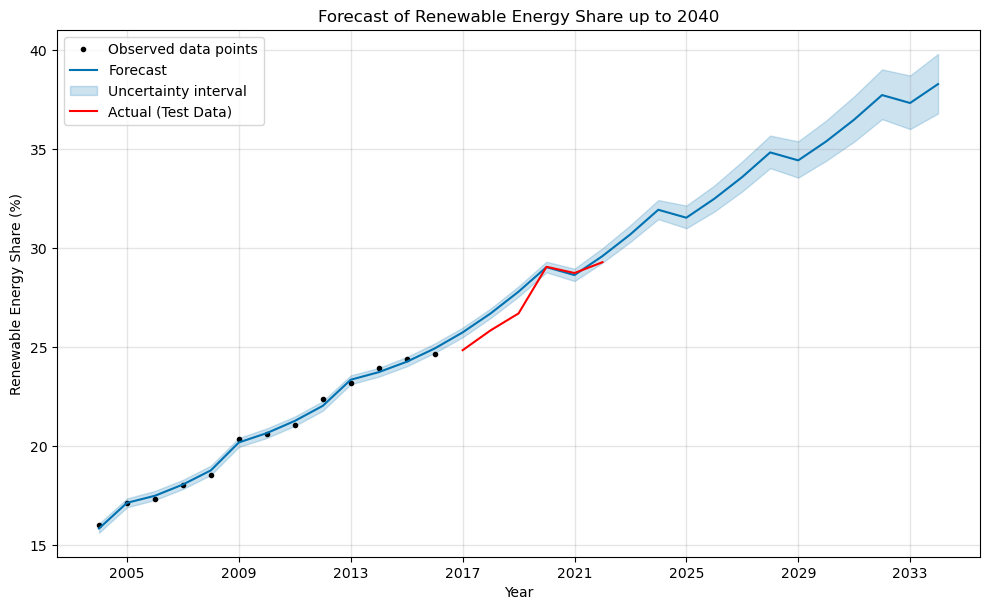

In [64]:
"""
Forecasts of the renewable energy share for the average of selected countries 
using the Prophet model. It prepares the data, fits the model, evaluates its performance 
on a test set, and visualizes the forecast results up to the year 2040.

"""


# Assign the data for renewable energy shares to a variable
data = share_renewables_energy

# Prepare Data for Prophet and Split into Train/Test
# Filter the data for the country labeled as 'AVERAGE'
country_data = data[data['Country'] == 'AVERAGE'] 
# Select relevant columns and rename them for Prophet
country_data = country_data[['Year', 'SRE_Value']].rename(columns={'Year': 'ds', 'SRE_Value': 'y'})
# Convert the 'Year' column to datetime format
country_data['ds'] = pd.to_datetime(country_data['ds'], format='%Y')  

# Define the split point; use the last 5 years for testing
split_point = int(len(country_data) * 0.7)
train_data = country_data.iloc[:split_point]  # Training data
test_data = country_data.iloc[split_point:]    # Testing data

# Initialize and Fit Prophet Model on Training Data
model = Prophet(yearly_seasonality=True)  # Create a Prophet model with yearly seasonality
model.fit(train_data)  # Fit the model to the training data

# Create Future DataFrame for Test and Predict
# Creating a forecast for both training and test period
# Create future dates up to 2040
last_year = country_data['ds'].max().year  # Get the last year in the data
years_to_forecast = 2040 - last_year  # Calculate how many years to forecast
future = model.make_future_dataframe(periods=years_to_forecast, freq='Y')  # Create future dates
forecast = model.predict(future)  # Make predictions for the future dates

# Filter forecast results to include only dates up to 2040
forecast_2040 = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].query("ds.dt.year <= 2040")

# Evaluate Model Performance on Test Set
# Extract test predictions
test_forecast = forecast[['ds', 'yhat']].iloc[-len(test_data):]  # Get predictions for the test period
test_forecast['y_true'] = test_data['y'].values  # Add actual values for comparison

# Calculate Error Metrics
mae = mean_absolute_error(test_forecast['y_true'], test_forecast['yhat'])  # Mean Absolute Error
mse = mean_squared_error(test_forecast['y_true'], test_forecast['yhat'])  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print error metrics
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Step 6: Visualize the Forecast
fig = model.plot(forecast)  # Plot the forecasted values
plt.plot(test_data['ds'], test_data['y'], 'r-', label='Actual (Test Data)')  # Plot actual test data
plt.legend()  # Add a legend to the plot
plt.title('Forecast of Renewable Energy Share up to 2040')  # Set title
plt.xlabel('Year')  # Set x-axis label
plt.ylabel('Renewable Energy Share (%)')  # Set y-axis label
plt.show()  # Display the plot




**Discussion:** The displayed forecast presents the projected share of renewable energy in the EU by 2040, based on an analysis of data from 2004 to 2022. The forecast was generated using the Prophet model, a time series forecasting tool, and was tested on data from 2017 to 2022 for validation. According to the forecast, the share is declining every few years. 
Overall, the errors suggest that the forecasted values are within approximately 9 percentage points of the actual values on average. While there is some error, the closeness of MAE and RMSE indicates that the model doesn’t have large, inconsistent outliers in its errors.
Despite increasing shares of renewables over recent decades, the forecast indicates a gap between future renewable energy shares and the EU’s climate goals. According to the Renewable Energy Directive [8], 42.5% of energy should come from renewable sources by 2030. However, the projected share by 2030 is only around 35%. This shortfall highlights the need for significantly accelerated efforts to meet climate targets.  

## 5. Conclusion
 
Overall, this analysis found that there has been a gradual decrease in energy poverty in recent years when looking at different indicators of energy poverty. By cross-correlating different indicators with the share of renewable energy, it was found that there is no general correlation between the expansion of renewable energy and a reduction in energy poverty. However, it was found that countries with higher initial rates of inadequate home heating have significant potential to improve their energy conditions by increasing their reliance on renewable energy. However, more research on other factors influencing energy poverty is needed to establish causality and more precise results. The projections show that the EU climate targets, as defined in RED II, will not be met. Therefore, more efforts are needed to accelerate the transition to renewable energy, while ensuring that it is designed in an equitable way to reduce energy poverty and move closer to achieving the SDGs. 



## References

1. European Commission. The European Green Deal (COM/2019/640 final). Brussels: European Commission; 2019 [cited 2024 Nov 1]. Available from: https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX:52019DC0640
2. Widuto A. Energy poverty in the EU (PE 733.583). Members' Research Service, European Parliamentary Research Service; 2023 Sep.
3. United Nations. Goal 7: Affordable and clean energy. United Nations Sustainable Development Goals. [cited 2024 Nov 1]. Available from: https://sdgs.un.org/goals/goal7
4. Eurostat. Share of renewable energy in gross final energy consumption by sector. Available from: https://doi.org/10.2908/SDG_07_40
5. Eurostat. Population unable to keep home adequately warm by poverty status. Available from: https://doi.org/10.2908/ILC_MDES01
6. Eurostat. Number of people in arrears on utility bills. Available from: https://doi.org/10.2908/ILC_MDES07
7. World Bank. National accounts data, and OECD National Accounts data files. Available from: https://data.worldbank.org/indicator/NY.GDP.PCAP.CD
8. World Bank national accounts data, and OECD National Accounts data files https://data.worldbank.org/indicator/NY.GDP.PCAP.CD
9. European Union. Directive (EU) 2023/2413 of the European Parliament and of the Council of 18 October 2023 amending Directive (EU) 2018/2001, Regulation (EU) 2018/1999 and Directive 98/70/EC as regards the promotion of energy from renewable sources, and repealing Council Directive (EU) 2015/652. Official Journal of the European Union, L 321, 1-43. 2023 Oct 18 [cited 2024 Nov 1]. Available from: https://eur-lex.europa.eu/eli/dir/2023/2413/oj

## Appendix

In [5]:
"""


A. PRE-PROCESSING


"""





def load_and_clean_data(
    file_path, 
    relevant_columns=None, 
    drop_na_columns=None,
    fill_na_method=None,
    change_names=None,
    filters=None
):
    """
    Loads and cleans data from a specified file path.

    Parameters:
    - file_path: str, path to the CSV file.
    - relevant_columns: list, columns to keep in the dataset.
    - drop_na_columns: list, columns to check for NA values to drop rows. If None, uses relevant_columns.
    - fill_na_method: str, method to fill NA values (e.g., 'ffill', 'bfill'). If None, does not fill.
    - change_names: list, new names for the relevant_columns, applied in the same order.
    - filters: dict, optional conditions for filtering the data (e.g., {"geo": "DE"}).

    Returns:
    - pd.DataFrame: Cleaned DataFrame.
    """
    
    # Load the dataset
    data = pd.read_csv(file_path)
    
    # Keep only the relevant columns
    data = data[relevant_columns]
    
    # Convert the time column to integers for easy comparison, if necessary
    if data['TIME_PERIOD'].dtype == 'object':
        data['TIME_PERIOD'] = data['TIME_PERIOD'].str.replace('-S1', '').astype(int)
    data['TIME_PERIOD'] = pd.to_numeric(data['TIME_PERIOD'], errors='coerce')
    
    
    # Drop rows with NA values in specified columns
    drop_na_columns = drop_na_columns if drop_na_columns else data.columns.tolist()
    drop_na_columns = [col for col in drop_na_columns if col in data.columns]
    data.dropna(subset=drop_na_columns, inplace=True)
    
    # Fill remaining NA values if a method is provided
    if fill_na_method:
        data.fillna(method=fill_na_method, inplace=True)
    
    # Apply any specified filters
    if filters:
        for column, value in filters.items():
            data = data[data[column] == value]
            
    
    # Rename relevant columns if `change_names` is provided
    if change_names and len(change_names) == len(relevant_columns):
        rename_dict = dict(zip(relevant_columns, change_names))
        data.rename(columns=rename_dict, inplace=True)
        
    # Drop rows where the country is 'EU27_2020'
    data = data[data['Country'] != 'EU27_2020']
    
    # Drop duplicates and reset index
    data.drop_duplicates(inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    return data



"""



Visualization

"""








"""

**Generalized plot_indicator_trends Function**


This function will:


- Plot time trends for a specified indicator by country.
- Filter for specific countries if needed.
- Accept customization parameters for titles, labels, and plot type.



"""


def plot_indicator_trends(
    data, 
    time_col='Year', 
    value_col='OBS_VALUE', 
    group_col='Country', 
    countries=None, 
    title="Indicator Trends Over Time by Country", 
    xlabel="Time Period", 
    ylabel="Indicator Value", 
    plot_type='line'
):
    """
    Plots time trends for a specified indicator by country.

    Parameters:
    - data: pd.DataFrame, cleaned DataFrame containing time, value, and group columns.
    - time_col: str, column name for time periods (default: 'TIME_PERIOD').
    - value_col: str, column name for the indicator values (default: 'OBS_VALUE').
    - group_col: str, column name for grouping (e.g., 'geo' for countries).
    - countries: list, optional list of countries to filter by. If None, plots all countries.
    - title: str, title for the plot.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    - plot_type: str, type of plot ('line' or 'bar').
    """
    
    # Optionally filter by specified countries
    if countries:
        data = data[data[group_col].isin(countries)]
    
    # Initialize plot
    plt.figure(figsize=(12, 6))
    
    # Group data by the specified group column and plot for each group
    for group, group_data in data.groupby(group_col):
        if plot_type == 'line':
            plt.plot(group_data[time_col], group_data[value_col], label=group)
        elif plot_type == 'bar':
            plt.bar(group_data[time_col], group_data[value_col], label=group, alpha=0.7)
    
    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Legend outside plot
    plt.xticks(rotation=45)
    plt.grid(True)  # Adding grid for easier tracing of trends
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    

"""

    
Creating a **wrapper function** for each indicator


"""

#Share of renewables in total energy consumption by country (e.g., solar, wind, hydro, biomass).

def plot_share_renewables_energy(data, countries=None, start_year=None, end_year=None, title = "Renewable Energy Share Over Time by Country" ):
    """
    Wrapper function that calls `plot_indicator_trends` 
    with defaults for renewable energy trends visualization and an optional time range.
    
    Parameters:
    - data: pd.DataFrame containing renewable energy data.
    - countries: list of countries to include in the plot.
    - start_year: int or str, start of the time range (inclusive).
    - end_year: int or str, end of the time range (inclusive).
    """

    # Apply the time range filter if specified
    if start_year is not None:
        data = data[data['Year'] >= int(start_year)]
    if end_year is not None:
        data = data[data['Year'] <= int(end_year)]
    
    # Call the main plotting function with preset labels for renewable energy trends
    plot_indicator_trends(
        data=data, 
        time_col='Year', 
        value_col='SRE_Value', 
        group_col='Country', 
        countries=countries, 
        title=title, 
        xlabel="Year", 
        ylabel="Renewable Energy Share (%)"
    )
    
    

#Percentage of the population unable to keep their home adequately warm.


def plot_unable_heating_home(data, countries=None, start_year=None, end_year=None, title="Percentage of Population Unable to Keep Home Adequately Warm"):
    """
    Wrapper function that calls `plot_indicator_trends` for visualizing 
    the percentage of the population unable to keep their home adequately warm,
    with an optional time range filter and customizable title.
    
    Parameters:
    - data: pd.DataFrame containing population data unable to keep their home warm.
    - countries: list of countries to include in the plot.
    - start_year: int or str, start of the time range (inclusive).
    - end_year: int or str, end of the time range (inclusive).
    - title: str, title for the plot (default: "Percentage of Population Unable to Keep Home Adequately Warm").
    """

    # Apply the time range filter if specified
    if start_year is not None:
        data = data[data['Year'] >= int(start_year)]
    if end_year is not None:
        data = data[data['Year'] <= int(end_year)]
    
    # Call the main plotting function with specific labels for this indicator
    plot_indicator_trends(
        data=data, 
        time_col='Year', 
        value_col='UHH_Value', 
        group_col='Country', 
        countries=countries, 
        title=title, 
        xlabel="Year", 
        ylabel="Percentage Unable to Keep Home Warm (%)"
    )

    

# Number of people in arrears on utility bills

def plot_utility_bills_difficulty(data, countries=None, start_year=None, end_year=None, title="Percentage of Population Reporting Difficulty Paying Utility Bills"):
    """
    Wrapper function that calls `plot_indicator_trends` for visualizing 
    the percentage of the population reporting difficulty paying utility bills,
    with an optional time range filter and customizable title.
    
    Parameters:
    - data: pd.DataFrame containing utility bills difficulty data.
    - countries: list of countries to include in the plot.
    - start_year: int or str, start of the time range (inclusive).
    - end_year: int or str, end of the time range (inclusive).
    - title: str, title for the plot (default: "Percentage of Population Reporting Difficulty Paying Utility Bills").
    """

    # Apply the time range filter if specified
    if start_year is not None:
        data = data[data['Year'] >= int(start_year)]
    if end_year is not None:
        data = data[data['Year'] <= int(end_year)]
    
    # Call the main plotting function with specific labels for this indicator
    plot_indicator_trends(
        data=data, 
        time_col='Year', 
        value_col='UBD_Value', 
        group_col='Country', 
        countries=countries, 
        title=title, 
        xlabel="Year", 
        ylabel="Percentage Reporting Difficulty Paying Utility Bills (%)"
    )
    
    
    
    
"""


C. CAGR and ABS Growth



"""


def plot_share_different_years(df, value_col, year1, year2):
    """
    Plots the share value for two selected years for each country.

    Parameters:
    - df: pd.DataFrame: The DataFrame containing the country, year, and renewable energy share columns.
    - country_col: str: The name of the column with country names.
    - year_col: str: The name of the column with year values.
    - value_col: str: The name of the column with the values to consider.
    - year1: int: The first year to compare.
    - year2: int: The second year to compare.
    """
    
    country_col = 'Country'
    year_col = 'Year'

    # Filter the DataFrame for the selected years
    data_year1 = df[df[year_col] == year1][[country_col, value_col]].copy()
    data_year2 = df[df[year_col] == year2][[country_col, value_col]].copy()

    # Rename columns for clarity
    data_year1.columns = [country_col, f'{value_col}_{year1}']
    data_year2.columns = [country_col, f'{value_col}_{year2}']

    # Merge the two years' data on country
    merged_data = pd.merge(data_year1, data_year2, on=country_col)

    # Sort the merged DataFrame alphabetically by country name
    merged_data.sort_values(by=country_col, inplace=True)

    # Define colors
    year1_color = 'orange'
    year2_color = 'lightgreen'
    average_color = 'blue'  # Color for 'AVERAGE' country

    # Plotting
    plt.figure(figsize=(12, 6))
    bar_width = 0.35  # Width of the bars
    x = range(len(merged_data))

    # Plot bars for year 1
    plt.bar(x, merged_data[f'{value_col}_{year1}'], width=bar_width, 
            color=[average_color if country == 'AVERAGE' else year1_color for country in merged_data[country_col]], 
            label=f'Share in {year1}', alpha=0.7)

    # Plot bars for year 2
    plt.bar([p + bar_width for p in x], merged_data[f'{value_col}_{year2}'], width=bar_width, 
            color=[average_color if country == 'AVERAGE' else year2_color for country in merged_data[country_col]], 
            label=f'Share in {year2}', alpha=0.7)

    # Set x-ticks to be the country names
    plt.xticks([p + bar_width / 2 for p in x], merged_data[country_col], rotation=45)

    # Adding labels and title
    plt.xlabel('Countries')
    plt.ylabel(f'{value_col} (%)')
    plt.title(f'{value_col} Comparison: {year1} vs {year2}')
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()
    
    
    
def plot_CAGR(data, value_col , start_year, end_year):
    """
    Calculates the Compound Annual Growth Rate (CAGR) for each country 
    over the specified years and plots the results.
    Parameters:
    - data: pd.DataFrame, the dataset containing country names, years, and values.
    - start_year: int, the starting year for filtering the data.
    - end_year: int, the ending year for filtering the data.
    - year_col: str, the name of the column containing year information.
    - value_col: str, the name of the column containing the values to calculate the CAGR.
    - country_col: str, the name of the column containing country names.
    """
    
    year_col = 'Year'
    country_col = 'Country'

    # Filter the data for the specified year range
    filtered_data = data[(data[year_col] >= start_year) & (data[year_col] <= end_year)]

    # Calculate the initial and final values for each country
    cagr_df = filtered_data.groupby(country_col).agg(
        Initial_Value=(value_col, 'first'),
        Final_Value=(value_col, 'last'),
        Years=('Year', 'count')
    ).reset_index()

    # Calculate CAGR
    cagr_df['CAGR'] = ((cagr_df['Final_Value'] / cagr_df['Initial_Value']) ** (1 / (cagr_df['Years'] - 1))) - 1
    cagr_df['CAGR'] *= 100  # Convert to percentage

    # Sort the DataFrame by CAGR in descending order
    sorted_df = cagr_df.sort_values(by='CAGR', ascending=False)

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.bar(sorted_df[country_col], sorted_df['CAGR'], color='skyblue')
    plt.xlabel('Country')
    plt.ylabel('CAGR (%)')
    plt.title(f'Compound Annual Growth Rate in {value_col} by Country ({start_year} - {end_year})')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    
    
def plot_absolute_growth(data, value_col, start_year, end_year):
    """
    Calculates the absolute growth in renewable energy share for each country 
    over the specified years and plots the results.

    Parameters:
    - data: pd.DataFrame, the dataset containing country names, years, and values.
    - country_col: str, the name of the column containing country names.
    - year_col: str, the name of the column containing year information.
    - value_col: str, the name of the column containing the values to calculate growth.
    - start_year: int, the starting year for filtering the data.
    - end_year: int, the ending year for filtering the data.
    """
    
    year_col = 'Year'
    country_col = 'Country'
    
    # Filter the data for the specified year range
    filtered_data = data[(data[year_col] >= start_year) & (data[year_col] <= end_year)]

    # Calculate the initial and final values for each country
    absolute_growth_df = filtered_data.groupby(country_col).agg(
        Initial_Value=(value_col, 'first'),
        Final_Value=(value_col, 'last')
    ).reset_index()

    # Calculate Absolute Growth
    absolute_growth_df['Absolute_Growth'] = absolute_growth_df['Final_Value'] - absolute_growth_df['Initial_Value']

    # Sort the DataFrame by absolute growth in descending order
    sorted_df = absolute_growth_df.sort_values(by='Absolute_Growth', ascending=False)

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.bar(sorted_df[country_col], sorted_df['Absolute_Growth'], color='lightgreen')
    plt.xlabel('Country')
    plt.ylabel(f'Absolute Growth in {value_col}')
    plt.title(f'Absolute Growth in {value_col} by Country')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

